# Lecture 1c: Unsupervised Learning and Clustering Approaches
This lecture introduces the first unsupervised learning approaches we will explore: k-means clustering and self-organizing maps. We will use these algorithms to identify hidden patterns and structures in data without explicit guidance.

The key concepts covered in this lecture include:
* __Unsupervised learning__: is a type of machine learning that involves training algorithms on unlabeled data. Unsupervised learning aims to identify patterns and structures in data without explicit guidance. 
Unsupervised learning is particularly useful when dealing with large volumes of unstructured data or when the desired outcomes are unknown.
* __Clustering__: is a typical unsupervised learning technique that involves dividing a dataset into distinct groups, or clusters, based on the similarity of data points. Clustering algorithms aim to group data points that are more similar to each other than to those in different clusters.
* __K-means clustering__ is a popular and straightforward clustering algorithm that partitions a dataset into $k$ clusters. 
The algorithm iteratively assigns data points to the nearest cluster center and updates the cluster centers based on the mean of the assigned points.
* __Self-organizing maps (SOMs)__: are another unsupervised learning algorithm that uses a neural network to map high-dimensional data onto a lower-dimensional grid.

Lecture notes can be found: [here!](docs/Notes.pdf)

## Background: What is unsupervised learning and clustering?
Unsupervised learning is a branch of machine learning that deals with unlabeled data, aiming to discover hidden patterns and structures without predefined target variables. One of the most important tasks in unsupervised learning is clustering.

* __What is Clustering?__ Clustering is an unsupervised machine learning technique that organizes data points into groups, or clusters, based on their similarities without prior knowledge of the group memberships. This method is widely used for exploratory data analysis, enabling the discovery of patterns and relationships within complex datasets.

### Clustering approaches
Today, we'll consider [the k-means algorithm](https://en.wikipedia.org/wiki/K-means_clustering), arguably the most straightforward clustering algorithm. While relatively straightforward, we see that [k-means](https://en.wikipedia.org/wiki/K-means_clustering) has some shortcomings. Thus, in addition to the [k-means approach](https://en.wikipedia.org/wiki/K-means_clustering) there are several other algorithms:
* __Hierarchical clustering__ is an unsupervised machine learning technique that organizes data points into a tree-like structure of nested clusters, allowing for the identification of relationships and patterns within the dataset. This method can be implemented through two main approaches: agglomerative, which merges individual points into larger clusters, and divisive, which splits a single cluster into smaller ones.
* __Density-based spatial clustering of applications with noise (DBSCAN)__ is a density-based clustering algorithm that groups closely packed data points while effectively identifying outliers, making it particularly useful for datasets with noise and clusters of arbitrary shapes. By defining clusters as dense regions separated by areas of lower density, DBSCAN can efficiently discover meaningful patterns in complex data distributions
* __Gaussian mixture models (GMMs)__ are probabilistic models that represent a dataset as a combination of multiple Gaussian distributions, each characterized by its mean and covariance, allowing for identifying underlying subpopulations within the data. This approach is useful in clustering and density estimation, providing a flexible framework for modeling complex, multimodal distributions.

## K-means clustering
The K-means algorithm, originally developed by [Lloyd in the 1950s but not published until much later in 1982](https://ieeexplore.ieee.org/document/1056489), is our first example of $\texttt{unsupervised learning}$. 
K-means is a popular unsupervised machine learning algorithm for clustering data points $\mathbf{x}\in\mathcal{D}$ (feature vectors) into distinct a set of groups (clusters) $\mathcal{C} = \left\{\mathcal{c}_{1},\dots,\mathcal{c}_{K}\right\}$ based on _similarity_.

__Key ideas__
* __Initialization__. You give the data set $\mathbf{x}\in\mathcal{D}$, which contains `n` data vectors (measurements, observations, etc) $\mathbf{x}_{1},\dots,\mathbf{x}_{n}$ where each vector $\mathbf{x}_{i}$ has `m` features, and the number and (initial) locations of K-clusters to the algorithm. Each cluster $\mathcal{c}_{k}$ is represented by a centroid, i.e., the mean of the set of data points in the cluster $\left\{\mathbf{x}_{i}\right\}_{i\in\mathcal{c}_{k}}$. In the K-means approach, you have to tell the algorithm how many clusters and the initial location of each cluster. This initial guess is then iteratively refined.
* __Update__. The K-means algorithm employs an iterative process wherein data points are assigned to the nearest cluster centroid, and the centroids are subsequently updated based on the mean of the assigned points. This iterative process continues until a predetermined stopping criterion is satisfied.
* __Stopping__. There are several ways the K-means algorithm can terminate. The stopping criteria for the K-means clustering algorithm include when the cluster centroids do not change significantly, when data points remain in the same clusters across iterations, or when a maximum number of iterations is reached.

Check out a [k-means pseudo-code here!](figs/pcode-kmeans.pdf)

### Prerequisites and data
We set up the computational environment by including the `Include.jl` file and then load any needed resources, e.g., a sample dataset, to cluster, and we end by setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [5]:
include("Include.jl");

Today, we'll work with a [customer spending preferences dataset from Kaggle](https://www.kaggle.com/code/heeraldedhia/kmeans-clustering-for-customer-data?select=Mall_Customers.csv). This dataset was created learning customer segmentation concepts, known as [market basket analysis](https://en.wikipedia.org/wiki/Market_basket). We will use [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) analysis to explore this data.

In [7]:
originaldataset = CSV.read(joinpath(_PATH_TO_DATA, "mall-customers-dataset.csv"), DataFrame)

Row,id,gender,age,income,spendingscore
,Int64,String7,Int64,Int64,Int64
1,1,Male,19,15,39
2,2,Male,21,15,81
3,3,Female,20,16,6
4,4,Female,23,16,77
5,5,Female,31,17,40
6,6,Female,22,17,76
7,7,Female,35,18,6
8,8,Female,23,18,94
9,9,Male,64,19,3


__Hmmm__. We have [categorical fields](https://en.wikipedia.org/wiki/Categorical_variable). Let's remap the `gender::String7` categorical feature, which is a string, to a number, i.e., let `Male = -1` and `Female = 1.` It's much easier to use numbers than categorical data when looking at (and analyzing) this data later. We'll store the revised dataset in [the `dataset::DataFrame` variable](https://github.com/JuliaData/DataFrames.jl).
* __Note__: the original dataset did not include example shoppers who identified as non-binary. Hence, we transformed the original `gender::String7` field to ${-1,1}$. However, if non-binary shoppers were to enter the dataset, we could map them to a different number, e.g., `0`.

In [9]:
dataset = let
    treated_dataset = copy(originaldataset);
    transform!(treated_dataset, :gender => ByRow( x-> (x=="Male" ? -1 : 1)) => :gender); # maps gender to -1,1
    treated_dataset 
end;

In [10]:
D = dataset[:,2:end] |> Matrix; # build a data matrix, exclude the id col

#### Constants
Let's set some constants that we'll need in the examples below. See the comment next to the constant for a description of what it is, it's permissible values, etc.

In [12]:
n = nrow(dataset); # how many example data points do we have?
m = 4; # number of features
maxiter = 2000; # maximum iterations
K = 5; # number of clusters. Why do we pick 5?
ϵ = 1e-6; # tolerance for termination. We can set this to whatever we want

Finally, let's set up the color dictionary for the visualizations in the lecture. The keys of the `my_color_dictionary::Dict{Int64,RGB}` dictionary are the cluster indexes, while the values are the colors mapped to that index.

In [14]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e";
my_color_dictionary[2] = colorant"#0077b6";
my_color_dictionary[3] = colorant"#00b4d8";
my_color_dictionary[4] = colorant"#ffc300";
my_color_dictionary[5] = colorant"#e36414";

### Visualization and data exploration
What does the consumer shopping data look like? Let's plot different data views to see what we can see, e.g., are there obvious patterns or groups in the dataset?
* `Unhide` the code block below to see how we plotted the dataset using [the `Plots.jl` package](https://github.com/JuliaPlots/Plots.jl), and particularly the [`scatter(...)` function](https://docs.juliaplots.org/stable/api/#Plots.scatter-Tuple). An initial look at the data (`income` versus `spendingscore`) suggests that there are perhaps at least five groups (clusters) in the data. However, the groupings in other views, e.g., `age` versus `spendingscore` are not as obvious.

Specify the horizontal and vertical axes columns. Note the column names which are of [type `Symbol`](https://docs.julialang.org/en/v1/manual/metaprogramming/#Symbols), which is a special type unique string.

In [16]:
horizontal_column = :income; # x-axis
vertical_column = :spendingscore; # y-axis

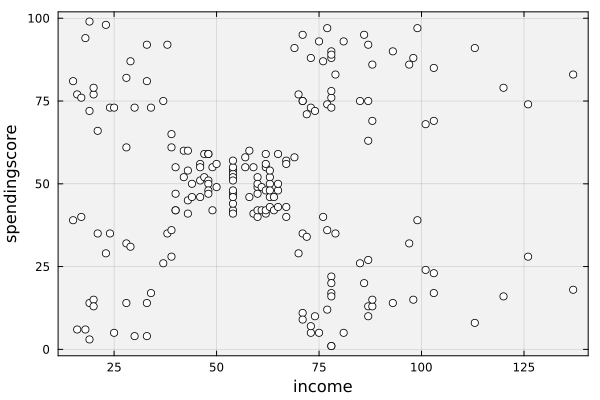

In [17]:
let
    
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot, styled the way we like
    scatter!(dataset[:, horizontal_column], dataset[:, vertical_column], label="", mec=:navy, c=:white)
    xlabel!("$(String(horizontal_column))");
    ylabel!("$(String(vertical_column))");
end

### k-means Implementation
We've developed an [initial k-means implementation](src/Cluster.jl) based on [our pseudo-code](figs/pcode-kmeans.pdf). Let's explore how this implementation performs on our sample dataset. 
* Build [a `MyNaiveKMeansClusteringAlgorithm` instance](src/Types.jl), which holds information about the clustering, i.e., the number of clusters `K::Int,` information about the dataset such as the number of features `m::Int,` and the number of points `n::Int,` and stopping criteria information such as the maximum number of iterations `maxiter::Int` and tolerance `ϵ::Float64`. We'll store this model in the `model::MyNaiveKMeansClusteringAlgorithm` variable.
* This is an example of [a factory type pattern](https://en.wikipedia.org/wiki/Factory_method_pattern), which uses [a `build(...)` method](src/Factory.jl) to construct and configure a complex object, i.e., set values for the properties on the model that must be computed. The [`build(...)` method](src/Factory.jl) takes the type of thing we want to build as the first argument, and the data required to construct the object (encoded [in a `NamedTupe` type](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple)) as the second argument.

In [19]:
model = build(MyNaiveKMeansClusteringAlgorithm, (
        maxiter = maxiter,
        dimension = m,
        number_of_points = n,
        K = K,
        ϵ = ϵ,
        scale_factor = 10.0, # scale of the data
));

The `model::MyNaiveKMeansClusteringAlgorithm` contains the data that we passed in and two derived fields that we computed in [the `build(...)` method](src/Factory.jl):
* The `centroids::Dict{Int64, Vector{Float64}}` dictionary holds the centroid values $\mu_{1},\dots,\mu_{K}$ for each cluster. The dictionary's keys are the cluster index, while the values are the `m`-dimensional centroids (means) of the data points in that cluster. We initialize the centroids randomly.
* The `assignments::Vector{Int64}` field is an `n`-dimensional vector holding the cluster index that each data point is assigned to. We initialize the assignments randomly.

In [21]:
model.centroids

Dict{Int64, Vector{Float64}} with 5 entries:
  5 => [1.03255, 4.96187, 4.93672, 3.46919]
  4 => [2.05039, 0.410962, 6.91241, 9.77938]
  2 => [2.22705, 0.511453, 0.831123, 1.57571]
  3 => [8.69289, 0.41948, 7.3395, 0.0544517]
  1 => [6.05625, 7.11903, 2.21811, 6.75235]

#### Visualize the initial centroids and assignments
`Unhide` the code block below to see how we plotted the initial assignments and centroids. Each data point, i.e., feature vector (shown by the circles), is initially assigned to a random cluster, and the centroids dictionary is initialized randomly, where the centroids are shown as `+.`
* Depending upon the scale factor, the initial centroid values will be on the lower left of the plot. The features will be randomly dispersed throughout the plane. The centroids' positions and the features' classification will be updated with each iteration of the k-means algorithm.

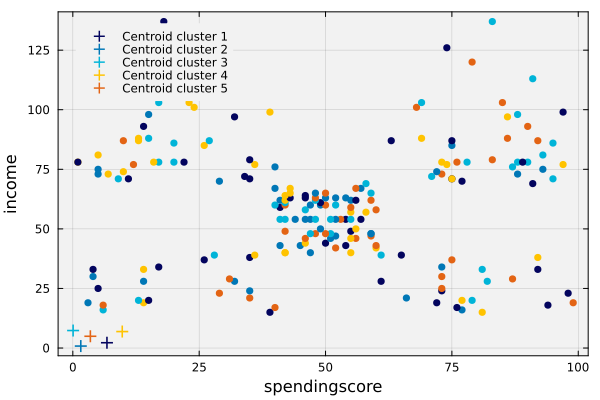

In [23]:
let

    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    horizontal_column = :spendingscore
    vertical_column = :income
    horizontal_index = findfirst(x-> x == String(horizontal_column), names(dataset)) - 1; # correct for the id col
    vertical_index = findfirst(x-> x == String(vertical_column), names(dataset)) - 1; # correct for the id col
    
    assignments = copy(model.assignments);
    for i ∈ eachindex(assignments);
        a = assignments[i];        
        scatter!([dataset[i, horizontal_column]], [dataset[i, vertical_column]], label="", c=my_color_dictionary[a], msc=my_color_dictionary[a]);
    end
    current();

    # plot the centroids -
    centroids = copy(model.centroids);
    for k ∈ 1:K
        c = centroids[k]
        scatter!([c[horizontal_index]], [c[vertical_index]], label="Centroid cluster $(k)", msc=my_color_dictionary[k], c=my_color_dictionary[k], 
            ms=6, markerstrokewidth=2, markershape = :plus)
    end
    current();

    xlabel!("$(String(horizontal_column))");
    ylabel!("$(String(vertical_column))");
end

#### Clustering
We call [the `cluster(...)` method](src/Cluster.jl) to refine our initial random cluster assignments and centroid values. The [`cluster(...)` method](src/Cluster.jl) takes a few arguments:

* `D::Array{<:Number, 2}`: The first argument is the data matrix `D::Array{<:Number,2}` which we want to cluster. The data matrix has the features along the columns, and each row is a data (feature) vector $\mathbf{x}$. Its values can be any type that is a subtype [of Number](https://docs.julialang.org/en/v1/base/numbers/#Core.Number). 
* `model::<: MyAbstractUnsupervisedClusteringAlgorithm`: The second argument is the cluster model instance, in this case, the `model::MyNaiveKMeansClusteringAlgorithm` instance that we built above. However, this can be any subtype of ` MyAbstractUnsupervisedClusteringAlgorithm.`
    * __Why?__ Suppose we have different k-means implementations or different clustering logic altogether. In that case, we can take advantage of Julia's multiple dispatch functionality by passing in a different clustering model. This provides a single method for a user to call, which calls a different implementation.
* `verbose::Bool`: The `verbose::Bool` argument tells our implementation whether to save data from each algorithm iteration. The default value is `false`. However, if the value is set to `true,` a save file holding the assignments, centroids, and loop index is written at each iteration.
* `d::Any`. The optional distance argument can be used to change how the similarity between feature vectors $\mathbf{x}\in\mathcal{D}$ is calculated. We can use [any metrics exported by the `Disra

The [`cluster(...)` method](src/Cluster.jl) returns cluster centroids, the assignments, and the number of iterations that it took to reach the final assignment in the `results::NamedTuple.`

In [25]:
result = cluster(D, model, verbose = false); # cluster the data

The final clustering shows the values of each feature vector assigned to one of the `K`-clusters (different colors), with the centroid of each cluster shown as a `+` value.

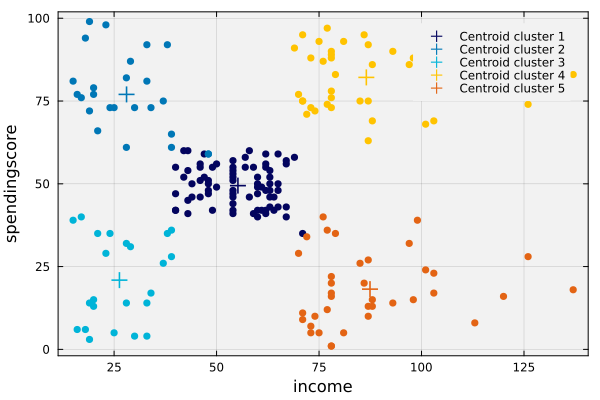

In [27]:
let

    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    horizontal_index = findfirst(x-> x == String(horizontal_column), names(dataset)) - 1; # correct for the id col
    vertical_index = findfirst(x-> x == String(vertical_column), names(dataset)) - 1; # correct for the id col
    
    assignments = result.assignments;
    for i ∈ eachindex(assignments);
        a = assignments[i];        
        scatter!([dataset[i, horizontal_column]], [dataset[i, vertical_column]], label="", c=my_color_dictionary[a], msc=my_color_dictionary[a]);
    end
    current();

    # plot the centroids -
    centroids = result.centroids;
    for k ∈ 1:K
        c = centroids[k]
        scatter!([c[horizontal_index]], [c[vertical_index]], label="Centroid cluster $(k)", msc=my_color_dictionary[k], c=my_color_dictionary[k], 
            ms=8, markerstrokewidth=2, markershape = :plus)
    end
    current();

    xlabel!("$(String(horizontal_column))");
    ylabel!("$(String(vertical_column))");
end

### What is in each cluster?
One obvious question is what is contained in each cluster. Specify the cluster index, and we'll build a table of the values that are contained in that cluster.

In [29]:
my_cluster_index = 2; # i ∈ {1,2,...,K}

In [30]:
let
    df = DataFrame(); 
    assignment = result.assignments;
    index_array = findall(a -> a == my_cluster_index, assignment);

    for i ∈ eachindex(index_array)
        a = index_array[i]; # what is the assignment
        row_df = (
                id = dataset[a,:id],
                c = my_cluster_index,
                gender = dataset[a,:gender],
                age = dataset[a,:age],
                income = dataset[a,:income],
                spendingscore = dataset[a, :spendingscore]
        );
        push!(df, row_df);
    end
    pretty_table(df, tf = tf_simple)
end

======== ======= ======== ======= ======== ================
     id       c   gender     age   income   spendingscore 
  Int64   Int64    Int64   Int64    Int64           Int64 
======== ======= ======== ======= ======== ================
      2       2       -1      21       15              81
      4       2        1      23       16              77
      6       2        1      22       17              76
      8       2        1      23       18              94
     10       2        1      30       19              72
     12       2        1      35       19              99
     14       2        1      24       20              77
     16       2       -1      22       20              79
     18       2       -1      20       21              66
     20       2        1      35       23              98
     22       2       -1      25       24              73
     24       2       -1      31       25              73
     26       2       -1      29       28              82
     28 

We can see the averages, i.e., the centroids of each feature in the `my_cluster_index::Int` by looking at the centroids dictionary:

In [32]:
let
    μ = result.centroids[my_cluster_index]
    df = DataFrame();
    row_df = (
        c = my_cluster_index,
        gender = μ[1],
        age = μ[2],
        income = μ[3],
        spendingscore = μ[4]
    );
    push!(df, row_df);
    pretty_table(df, tf=tf_simple)
end

======== ========= ========= ========= ================
      c    gender       age    income   spendingscore 
  Int64   Float64   Float64   Float64         Float64 
======== ========= ========= ========= ================
      2      0.12     24.96     28.04            77.0
======== ========= ========= ========= ================


## What are the problems with k-means?
On this sample dataset, our k-means implementation seems to work ok. However, what are the problems with the approach we might encounter in practice with an arbitrary dataset? Let's explore a few of these issues:
* __Fixed (unspecified) number of clusters__. K-means requires the user to specify the number of clusters, $k$, in advance. This requirement poses a challenge, as choosing an inappropriate $k$ can lead to poor clustering results. For example, if $k$ is set too high, it may cause overfitting, where noise is regarded as distinct clusters. Conversely, setting $k$ too low may result in losing vital data structure.
* __Sensitivity to initial conditions__. The K-means method is sensitive to the initial placement of centroids. Our implementation randomly initializes cluster centers, and different initializations can lead to convergence at various clustering outcomes. This variability may affect the reproducibility of the clustering.
* __Sensitivity to outliers__. The presence of outliers can significantly compromise the accuracy of K-means clustering results. Outliers can skew the centroids' positions, resulting in misleading cluster assignments. Preprocessing steps may be required to address the impact of outliers.
* __Overlapping clusters__. In cases where clusters overlap, K-means does not have an intrinsic mechanism for handling uncertainty regarding which cluster a data point belongs to. This can result in ambiguous assignments and reduced clarity in cluster definitions. 

## Extra: Do you want to watch each iteration?
If the `verbose::Bool` flag is set to `true,` then a save file holding information about the algorithm progress will be written at each iteration. We can reload that data to generate plots of cluster assignments and centroid values as the algorithm works. 
* To do this, set the `write_the_kmeans_movie_frames::Bool` variable to `true.` The frames will then be written to the `frames` directory. Otherwise, to not write the images, set the `write_the_kmeans_movie_frames::Bool` to a value of `false`.

In [35]:
write_the_kmeans_movie_frames = true;

In [36]:
let

    if (write_the_kmeans_movie_frames == true)
    
        # get some data from the run -
        number_of_iterations = result.loopcount; # how many steps before we terminated
    
        # setup information for the plot -
        horizontal_column = :spendingscore
        vertical_column = :income
        horizontal_index = findfirst(x-> x == String(horizontal_column), names(dataset)) - 1; # correct for the id col
        vertical_index = findfirst(x-> x == String(vertical_column), names(dataset)) - 1; # correct for the id col
    
        for i ∈ 1:number_of_iterations
            data = load(joinpath(_PATH_TO_TMP, "data-$(i).jld2")); # load data for iteration i

            p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
            assignments = data["assignments"];
            for i ∈ eachindex(assignments);
                a = assignments[i];        
                scatter!([dataset[i, horizontal_column]], [dataset[i, vertical_column]], label="", c=my_color_dictionary[a], msc=my_color_dictionary[a]);
            end
    
            # plot the centroids -
            centroids = data["centroids"];
            for k ∈ 1:K
                c = centroids[k]
                scatter!([c[horizontal_index]], [c[vertical_index]], label="Centroid cluster $(k)", msc=my_color_dictionary[k], c=my_color_dictionary[k], 
                    ms=6, markerstrokewidth=2, markershape = :plus)
            end
            current();
            savefig(joinpath(_PATH_TO_FRAMES, "Tmp-$(i).pdf"))
            # IJulia.clear_output(true)
        end
    end
end